# Imports

In [1]:
import numpy as np
import scipy.optimize as opt
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from sympy import legendre_symbol

# Defining Relevant Functions

In [79]:
def cazac_system(x):
    n = int(len(x)/2)
    a = x[:n]
    b = x[n:]
    F = np.zeros(3*n-2)
    F[:n] = a**2 + b**2 - 1
    for k in np.arange(1,n):
        F[n+k-1] = np.sum(a*np.roll(a,k)+b*np.roll(b,k))
        F[2*n-2+k] = np.sum(a*np.roll(b,k)-b*np.roll(a,k))
    return F

def aperiodic_ambiguity(seq):
    n = len(seq)
    AF = np.zeros((2*n-1,n),dtype='complex')
    M = np.eye(n)*np.exp(2*np.pi*1j*np.arange(n)/n)
    
    # Negative time shift side
    for k in np.arange(1,n):
        for l in np.arange(n):
            translate_seq = np.zeros(n,dtype='complex')
            for j in np.arange(k,n):
                translate_seq[j] = seq[j-k]
            shift_seq = np.conjugate(np.linalg.matrix_power(M,l)@seq)
            AF[n-1-k,l] = np.dot(translate_seq,shift_seq)
    # Positive time shift side
    for k in np.arange(n):
        for l in np.arange(n):
            translate_seq = np.zeros(n,dtype='complex')
            for j in np.arange(n-k):
                translate_seq[j] = seq[j+k]
            shift_seq = np.conjugate(np.linalg.matrix_power(M,l)@seq)
            AF[n-1+k,l] = np.dot(translate_seq,shift_seq)
    return AF

def aperiodic_autocorrelation(seq):
    n = len(seq)
    AC = np.zeros(2*n-1,dtype='complex')
    
    # Negative time shift side
    for k in np.arange(1,n):
        translate_seq = np.zeros(n,dtype='complex')
        for j in np.arange(k,n):
            translate_seq[j] = seq[j-k]
        conj_seq = np.conjugate(seq)
        AC[n-1-k] = np.dot(conj_seq,translate_seq)
    # Positive time shift side
    for k in np.arange(n):
        translate_seq = np.zeros(n,dtype='complex')
        for j in np.arange(n-k):
            translate_seq[j] = seq[j+k]
        conj_seq = np.conjugate(seq)
        AC[n-1+k] = np.dot(conj_seq,translate_seq)
    return AC

In [142]:
#lengths = np.array([7,11,17,23,29,37,43,53,59,67,71])
lengths = np.array([11,13,17,23,29,37,43,47])
sequences = 1000
max_trials = 20000
threshold = 10**(-8)

In [143]:
result_psl = np.zeros((len(lengths),sequences))
result_isl = np.zeros((len(lengths),sequences))
for n in tqdm(lengths):
    opt_result = []
    trials = 0
    success = 0
    while (trials < max_trials) and (success < sequences):
        x0 = -1+2*np.random.rand((2*n))
        result = opt.least_squares(cazac_system,x0,jac='3-point',ftol=10**(-12),xtol=10**(-12),gtol=10**(-12))
        if (result.cost < threshold):
            sequence = result.x[:n]+1j*result.x[n:]
            opt_result.append(sequence)
            AC = aperiodic_autocorrelation(sequence)
            result_psl[np.where(lengths==n)[0],success] = np.max((np.abs(AC[:n-1]),np.abs(AC[n:])))/n
            result_isl[np.where(lengths==n)[0],success] = (np.sum(np.abs(AC[:n-1]))+np.sum(np.abs(AC[n:])))/n**2
            success = success + 1
        trials = trials+1
    

100%|████████████████████████████████████████| 8/8 [20:26:58<00:00, 9202.26s/it]


In [110]:
print(result_psl[0,:])
#print(result_isl)

[0.14285714 0.20203051 0.26989399 0.28571429 0.32099709 0.28571429
 0.14285714 0.30464393 0.27235045 0.20203051]


In [144]:
chu_psl = []
chu_isl = []
bjorck_psl = []
bjorck_isl = []
for n in lengths:
    x_chu = np.exp(np.pi*1j*np.arange(n)*(np.arange(n)-1)/n)
    AC = aperiodic_autocorrelation(x_chu)
    chu_psl.append(np.max((np.abs(AC[:n-1]),np.abs(AC[n:])))/n)
    chu_isl.append((np.sum(np.abs(AC[:n-1]))+np.sum(np.abs(AC[n:])))/n**2)
    x_bjorck = np.zeros(n,dtype='complex')
    if n%4 == 3:
        for i in np.arange(n):
            if legendre_symbol(i,n) == -1:
                x_bjorck[i] = np.exp(1j*np.arccos((1-n)/(1+n)))
            else:
                x_bjorck[i] = 1
    if n%4 == 1:
        for i in np.arange(n):
            x_bjorck[i] = np.exp(1j*legendre_symbol(i,n)*np.arccos(1/(1+np.sqrt(n))))
    AC = aperiodic_autocorrelation(x_bjorck)
    bjorck_psl.append(np.max((np.abs(AC[:n-1]),np.abs(AC[n:])))/n)
    bjorck_isl.append((np.sum(np.abs(AC[:n-1]))+np.sum(np.abs(AC[n:])))/n**2)

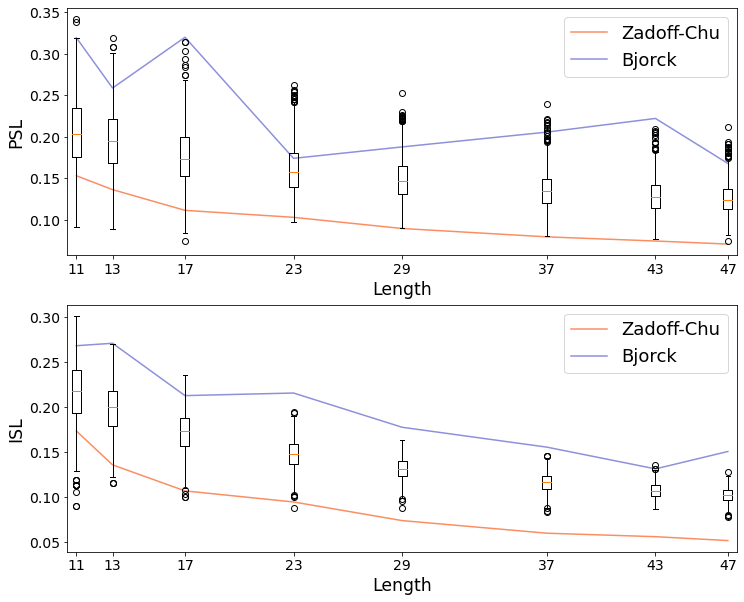

In [242]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
im_chu = ax.plot(lengths,chu_psl,c='#fc8d62',label='Zadoff-Chu')
im_bjorck = ax.plot(lengths,bjorck_psl,c='#8d90db',label='Bjorck')
im_num = ax.boxplot(result_psl.T,positions=lengths)
ax.set_xlabel('Length',size='xx-large')
ax.set_ylabel('PSL',size='xx-large')
ax.legend(prop={'size':18})
ax.tick_params(axis='both', labelsize=14)
im2_chu = ax2.plot(lengths,chu_isl,c='#fc8d62',label='Zadoff-Chu')
im2_bjorck = ax2.plot(lengths,bjorck_isl,c='#8d90db',label='Bjorck')
im2_num = ax2.boxplot(result_isl.T,positions=lengths)
ax2.set_xlabel('Length',size='xx-large')
ax2.set_ylabel('ISL',size='xx-large')
ax2.legend(prop={'size':18})
ax2.tick_params(axis='both', labelsize=14)

In [243]:
fig.savefig('psl_compare_1k.png',bbox_inches='tight')

In [147]:
np.savetxt('psl_compare_data_1k.csv',result_psl)
np.savetxt('isl_compare_data_1k.csv',result_isl)

In [150]:
n = 43
max_trials = 20
threshold = 10**(-8)

In [151]:
trials = 0
while (trials < max_trials):
    x0 = -1+2*np.random.rand((2*n))
    result = opt.least_squares(cazac_system,x0)
    if (result.cost < threshold):
        sequence = result.x[:n]+1j*result.x[n:]
        trials = max_trials+1
    else:
        trials = trials+1

In [152]:
x_chu = np.exp(np.pi*1j*np.arange(n)*(np.arange(n)-1)/n)
AF_chu = aperiodic_ambiguity(x_chu)
AF_long = aperiodic_ambiguity(sequence)

In [72]:
np.abs(AF_chu[n-1,0])

53.0

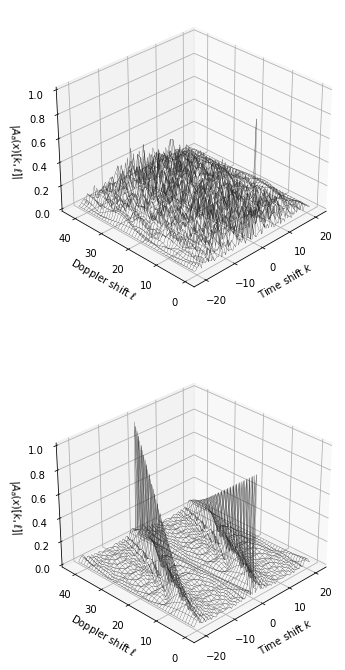

In [211]:
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(211,projection='3d')
ax2 = fig.add_subplot(212,projection='3d')
x = np.linspace(-np.floor(n/2),np.floor(n/2),2*n-1)
y = np.linspace(0,n-1,n)
X, Y = np.meshgrid(x,y)
#Z = np.ones((len(x),len(y)))
Z = np.abs(AF_long)/n
Z2 = np.abs(AF_chu)/n
ax.plot_wireframe(X,Y,Z.T,color='#202020',linewidth=0.25)
ax.set_xlabel(r'Time shift $k$')
ax.set_ylabel(r'Doppler shift $\ell$')
ax.set_zlabel(r'$|A_a(x)[k,\ell]|$')
ax.view_init(30,225)
ax2.view_init(30,225)
ax2.plot_wireframe(X,Y,Z2.T,color='#202020',linewidth=0.25)
ax2.set_xlabel(r'Time shift $k$')
ax2.set_ylabel(r'Doppler shift $\ell$')
ax2.set_zlabel(r'$|A_a(x)[k,\ell]|$')
#ax.plot_wireframe(Y,X,Z.T,cmap='binary',color='black')
#ax.invert_xaxis()
fig.savefig('long_ambiguity_compare.png',bbox_inches='tight')

In [210]:
plt.savefig('long_ambiguity_compare.png')

<Figure size 432x288 with 0 Axes>